# Taxonomy classification

**Overview:**<br>
[1. Setup](#setup)<br>
[2. Taxonomy assignment](#tax_assignment_main)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Taxonomy assignment](#tax_assignment)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Taxonomy visualization](#tax_visualization)<br>

<a id='setup'></a>

## 1. Setup

In [23]:
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

from scipy import stats
import qiime2 as q2

%matplotlib inline

# location of the data and all the results produced by this notebook 
data_dir = 'project_data'

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

Download the `FeatureData[Sequence]` from our data which was made in the FirstLook.ipynb:

In [ ]:
! wget -nv -O $data_dir/rep-seqs.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Sequences_rep_set.qza'

Download the `FeatureTable[Frequency]` containing a mapping of the dereplicated sequences to samples from our data which was made in the FirstLook.ipynb:



In [ ]:
! wget -nv -O $data_dir/table.qza 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=Feature_table.qza'

In [ ]:
#! wget -nv -O $data_dir/cleaned_sample_meta_data.tsv 'https://polybox.ethz.ch/index.php/s/MBLSUQXzglnn66u/download?path=%2F&files=cleaned_sample_meta_data.tsv'

In [ ]:
! wget -nv -O $data_dir/metadata.tsv 'https://polybox.ethz.ch/index.php/s/QqbHeUIpIR0okB8/download'

<a id='tax_assignment_main'></a>

## 2. Taxonomy assignment

To classify the sequences into bacterial species, the assignment can be done with BLAST search of the sequences against a data base of known sequence. The methode used here is a machine learning classifier which is trained on a reference database to recognize the bacterial species in the samples.  


In the following cell the classifier which we already used in class is downloaded. 
(The Greengenes database is comprised of 16S rRNA genes)

In [ ]:
! wget -nv -O $data_dir/515f-806r-classifier.qza https://data.qiime2.org/2021.4/common/gg-13-8-99-515-806-nb-classifier.qza

<a id='tax_assignment'></a>

### 2.1 Taxonomy assignment


After downloading the classifier we can assign taxonomy labels to the ASVs from the project data. The `classify-sklearn` action from the `feature-classifier` plugin needs two things: 
- the classifier which was trained the previous step
- the sequences to be classified

This step will require the `FeatureData[Sequence]` artifact (containing our ASVs) that were generated beforhand.


In [ ]:
! qiime feature-classifier classify-sklearn \
    --i-classifier $data_dir/515f-806r-classifier.qza \
    --i-reads $data_dir/rep-seqs.qza \
    --o-classification $data_dir/taxonomy_1.qza

A new `FeatureData[Taxonomy]` artifact should be created, containing our taxonomic assignments per feature.

In [ ]:
! qiime tools peek $data_dir/taxonomy_1.qza

<a id='tax_visualization'></a>

### 2.4 Taxonomy visualization

The composition of the project samples is in the coming section analyzed . A tabular representation of all the features labeled with their corresponding taxonomy is created:

In [ ]:
! qiime metadata tabulate \
    --m-input-file $data_dir/taxonomy_1.qza \
    --o-visualization $data_dir/taxonomy_1.qzv

In the table an ID of every ASV is asigned with its corresponding taxonomic assignment and the prediction confidence.

In [10]:
Visualization.load(f'{data_dir}/taxonomy_1.qzv')

<visualization: Visualization uuid: 443f1676-7952-4738-a603-96ed7e6aef7f>

The taxonomic information per feature can be combined with the information about the samples to get an idea of the taxonomic distribution of species is in the different samples. The data can be visualized in a bar plot. Each bar represents a single sample and is broken down proportionally to counts of every taxon.

In [ ]:
Visualization.load(f'{data_dir}/rep-seqs.qzv')

In [ ]:
! qiime taxa barplot \
    --i-table $data_dir/table.qza \
    --i-taxonomy $data_dir/taxonomy_1.qza \
    --m-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/taxa-bar-plots.qzv

In [9]:
Visualization.load(f'{data_dir}/taxa-bar-plots.qzv')

<visualization: Visualization uuid: 95ab3576-640d-4240-8d4f-cefde1ae3635>

In [41]:
taxonomy_artifact = q2.Artifact.load(f'{data_dir}/taxonomy_1.qza')
taxonomy_df = taxonomy_artifact.view(pd.DataFrame)
tax = taxonomy_df.sort_values(by=['Confidence'])

Feature ID
e77da968091341d724c9ba6100ef1bd6    0.700526
3cdd5aad050b728ee09ba86a9f57e411    0.701296
0add8206b1eabc1b07426b22fda10148    0.701587
b6b61068ccc8902684b801017a0eb368    0.702097
f663dd604f793f22ce20452b09494608    0.702593
                                      ...   
c2e60172ca7c7e2c7340979355f5b72e    1.000000
85787097eb7bb567fd2468eb4d8bf935    1.000000
3eb7d15a2507bc677303e1cf8ef8a555    1.000000
9e3e61ab8f8501e49dfd6f9a0af91d14    1.000000
8f6a251366404ebc907e9cb404c07ffe    1.000000
Name: Confidence, Length: 5066, dtype: float64

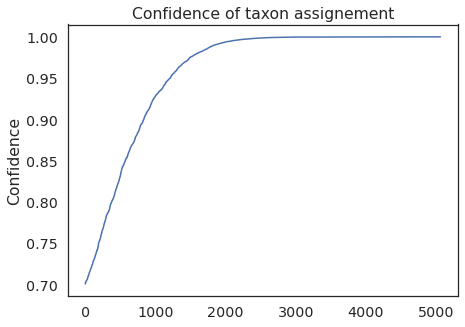

In [54]:
tax['Confidence'] = tax['Confidence'].astype(float)
selection = tax

sns.set(rc={'figure.figsize': (7, 5)}, style='white')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn's barplot
    ax = sns.lineplot(x=range(0, len(tax)), y=selection['Confidence'])
    
    # matplotlib's customization
    ax.set_title('Confidence of taxon assignement')
